# 支持向量机

前言：虽然目前可以在Scikit-learn程序包中直接调用支持向量机算法，但是感觉有些部分还不是很清楚，正好看到如下的推文，故打算自己实践一下。
链接：https://mp.weixin.qq.com/s?__biz=MzAwNjM1ODkxNQ==&mid=2650890246&idx=1&sn=ff4c4f926299efe80020e445962b4fa8&chksm=80fb52eab78cdbfc657e1d2f5547d23d71cb5f686df3aa7defc5d2d41f4174c2b0b17a91fafd&mpshare=1&scene=1&srcid=&key=db761600f54d432fbfa81d8d8fd82e721388bc3be6a6c13c6e86f7605b13e15270db51eabfcfe557f1384141d281bba94399c757f1f8b70c0a0b81d350d1df83fbee404e8a5a2ed802a17295e3c3fd8a&ascene=1&uin=MTEwNzI4MDEwMQ%3D%3D&devicetype=Windows+10&version=62060739&lang=zh_CN&pass_ticket=3cjSEDupvZPJDPdtau5jwgNUL0I92EdqGpMYoRsCV%2F%2BToWx9nFj74TBfn58raeRN

**正式进入**

支持向量机（support vector machine，SVM）是非常强大、灵活的有监督学习算法，既可用于分类，也可用于回归。在本节中，我们将介绍支持向量机的原理，并用它解决分类问题。首先还是导入需要用的程序库：

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

## 支持向量机的由来

我们首先对每个类进行了随机分布的假设，然后用生成的模型估计新数据点的标签。这里将介绍判别分类方法：用一条分割线（二维空间中的直线或曲线）或者流形体（多维空间中的曲线、曲面等概念的推广）将各种类型分割开。

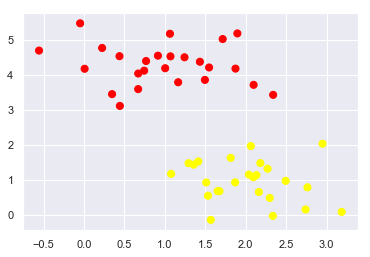

In [2]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

线性判别分类器尝试画一条将数据分成两部分的直线，这样就构成了一个分类模型。对于上图的二维数据来说，这个任务其实可以手动完成。但是我们马上发现一个问题：在这两种类型之间，有不止一条直线可以将它们完美分割。

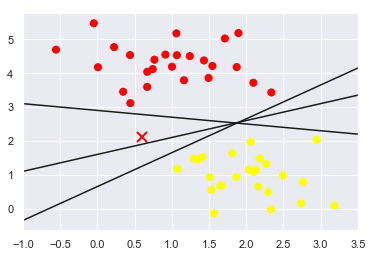

In [90]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

虽然这三个不同的分类器都能完美地判别这些样本，但是选择不同的分割线，可能会让新的数据点（例如图中的“X”点）分配到不同的标签。显然，“画一条分割不同类型的直线”还不够，我们需要进一步思考。

## 支持向量机：边界最大化

支持向量机提供了改进这个问题的方法，它直观的解释是：不再画一条细线来区分类型，而是画一条到最近点边界、有宽度的线条。

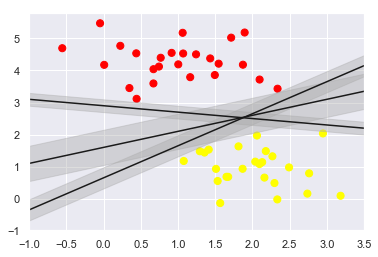

In [91]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

在支持向量机中，选择边界最大的那条线是模型最优解。支持向量机其实就是一个边界最大化评估器。

### 1 拟合支持向量机

来看看这个数据的真实拟合结果：用Scikit-Learn的支持向量机分类器在数据上训练一个SVM 模型。这里用一个线性核函数，并将参数C 设置为一个很大的数（后面会介绍这些设置的意义）。

为了实现更好的可视化分类效果，创建一个辅助函数画出SVM 的决策边界。

In [174]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10, probability=True)
model.fit(X, y)

SVC(C=10000000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [116]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """画二维SVC的决策函数"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # 创建评估模型的网格
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x) # 生成网格数据
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # 画决策边界和边界
    ax.contour(X, Y, P, colors='k', # 利用等高线绘制函数
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # 画支持向量
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=50, linewidth=1, facecolors='purple'); # modified
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

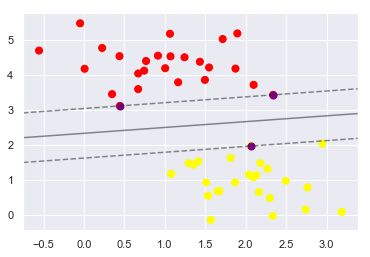

In [117]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

这就是两类数据间隔最大的分割线。你会发现有一些点(紫色)正好就在边界线上,这些点是拟合的关键支持点，被称为支持向量，支持向量机算法也因此得名。在Scikit-Learn里面，支持向量的坐标存放在分类器的support_vectors_属性中：

In [118]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

另在线性分类器中，各特征的系数存在coef_属性中，各支持向量的权重存储在dual_coef_属性中，且：
    $$coef_ = \sum(dual\_coef\_*support\_vectors\_)$$

样本的预测值可由decision_function(X)得到，常数项存在intercept_属性中，预测值也可以按如下方法计算的到
    $$decision\_function(X) = \sum(coef\_*X)+intercept\_$$

线性核函数相对简单，系数和预测值可以通过上述方法计算得到。其他核函数原理类似，具体的公式可以查询相关资料。

In [147]:
print('coef of features by classifier',model.coef_)
coef_cal = np.sum(np.multiply(model.support_vectors_,model.dual_coef_.T),axis=0)
print('coef of features by manual computation',coef_cal)

print('decision value of X[0] by decision_function',model.decision_function([X[0,:]]))
decision_value_cal = np.sum(np.multiply(model.coef_,X[0]))+model.intercept_
print('decision value of X[0] by manual computation',decision_value_cal)

coef of features by classifier [[ 0.23525694 -1.41250783]]
coef of features by manual computation [ 0.23525694 -1.41250783]
decision value of X[0] by decision_function [1.46710653]
decision value of X[0] by manual computation [1.46710653]


分类器能够成功拟合的关键因素，就是这些支持向量的位置——任何在正确分类一侧远离边界线的点都不会影响拟合结果！从技术角度解释的话，是因为这些点不会对拟合模型的损失函数产生任何影响，所以只要它们没有跨越边界线，它们的位置和数量就都无关紧要

例如，可以分别画出数据集前60 个点和前120 个点的拟合结果，并进行对比

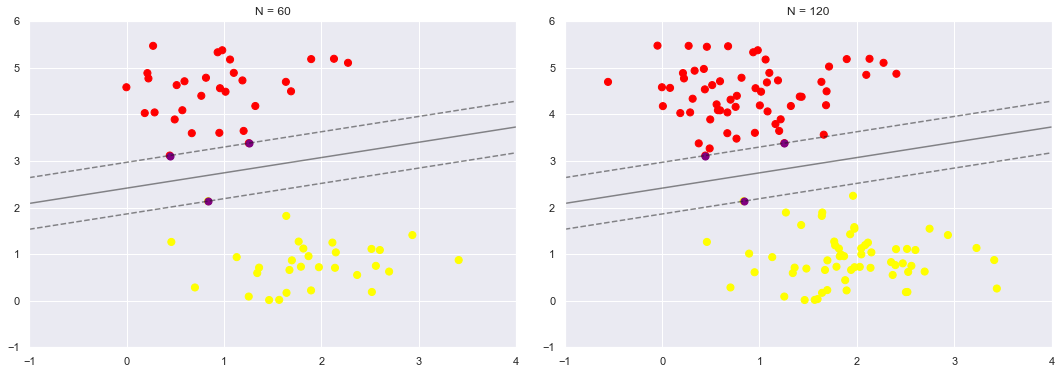

In [96]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

我们在左图中看到的是前60个训练样本的模型和支持向量。在右图中，虽然我们画了前120 个训练样本的支持向量，但是模型并没有改变：左图中的3个支持向量仍然适用于右图。这种对远离边界的数据点不敏感的特点正是SVM 模型的优点之一。

In [97]:
from ipywidgets import interact, fixed
interact(plot_svm, N=[10, 200], ax=fixed(None));

interactive(children=(Dropdown(description='N', options=(10, 200), value=10), Output()), _dom_classes=('widget…

### 2  超越线性边界：核函数SVM模型

将SVM模型与核函数组合使用，功能会非常强大。那时，我们将数据投影到多项式和高斯基函数定义的高维空间中，从而实现用线性分类器拟合非线性关系。

在SVM模型中，我们可以沿用同样的思路。为了应用核函数，引入一些非线性可分的数据。

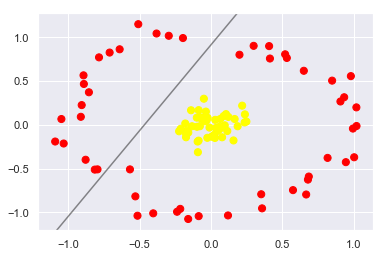

In [98]:
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

显然，这里需要用非线性判别方法来分割数据。例如，一种简单的投影方法就是计算一个以数据圆圈（middle clump）为中心的径向基函数：

In [99]:
r = np.exp(-(X ** 2).sum(1))

可以通过三维图来可视化新增的维度

In [100]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[0,-90,90], azip=(-180, 180), # modified
         X=fixed(X), y=fixed(y));

interactive(children=(Dropdown(description='elev', options=(0, -90, 90), value=0), IntSlider(value=30, descrip…

增加新维度之后，数据变成了线性可分状态。如果现在画一个分割平面，例如r = 0.7，即可将数据分割。

我们还需要仔细选择和优化投影方式；如果不能将径向基函数集中到正确的位置，那么就得不到如此干净、可分割的结果。通常，选择基函数比较困难，我们需要让模型自动指出最合适的基函数。

一种策略是计算基函数在数据集上每个点的变换结果，让SVM算法从所有结果中筛选出最优解。这种基函数变换方式被称为核变换，是基于每对数据点之间的相似度（或者核函数）计算的。

这种策略的问题是，如果将N个数据点投影到N维空间，当N不断增大的时候就会出现维度灾难，计算量巨大。但由于核函数技巧(http://bit.ly/2fStZeA) 提供的小程序可以隐式计算核变换数据的拟合，也就是说，不需要建立完全的N维核函数投影空间！这个核函数技巧内置在SVM模型中，是使SVM方法如此强大的充分条件。

在Scikit-Learn 里面我们可以应用核函数化的SVM模型将线性核转变为RBF（径向基函数）核，设置kernel模型超参数即可.

In [101]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

/home/huiying/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

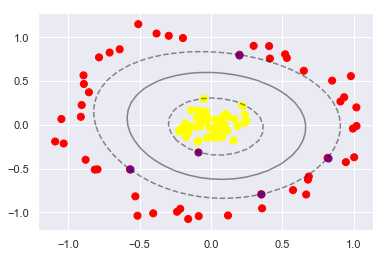

In [102]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

通过使用这个核函数化的支持向量机，我们找到了一条合适的非线性决策边界。在机器学习中，核变换策略经常用于将快速线性方法变换成快速非线性方法，尤其是对于那些可以应用核函数技巧的模型.

### 3  SVM优化：软化边界

到目前为止，我们介绍的模型都是在处理非常干净的数据集，里面都有非常完美的决策边界。但如果你的数据有一些重叠该怎么办呢？例如，有如下所示一些数据

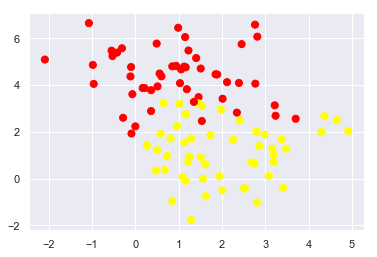

In [103]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

为了解决这个问题，SVM实现了一些修正因子来“软化”边界。为了取得更好的拟合效果，它允许一些点位于边界线之内。边界线的硬度可以通过超参数进行控制，通常是C。

如果C很大，边界就会很硬，数据点便不能在边界内“生存”；如果C比较小，边界线比较软，有一些数据点就可以穿越边界线。

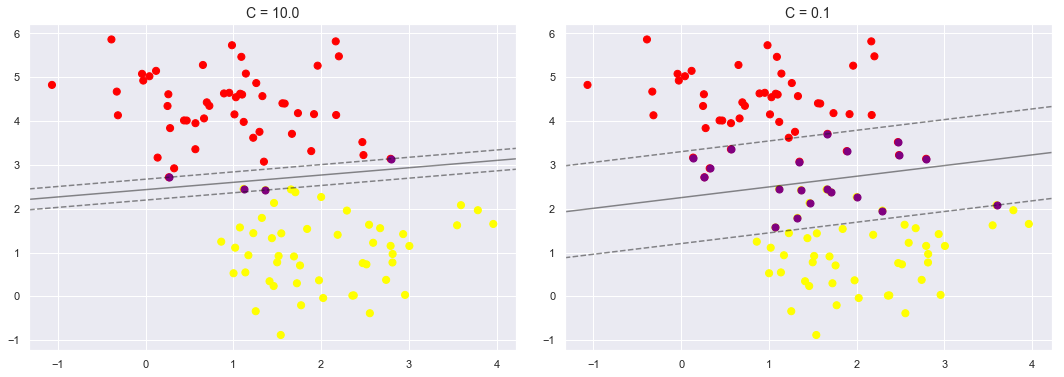

In [104]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

参数C 的最优值视数据集的具体情况而定，通过交叉检验或者类似的程序进行计算

### 4  SVM预测概率: decision_function vs predict_proba

支持向量机算法是不直接提供预测概率,相关的概率估计方法研究早年有许多.

对于scikit-learn包中的SVC函数来说,需要在函数初始化时将probability设置为**True**,才能使用predict_proba和predict_log_proba两种方法输入估计的预测概率,否在只能使用decision_function输出到决策函数的距离,记为f(具体的距离计算方法此处不讨论).

当probability=True时，将启用预测概率概率估计(predict_proba和predict_log_proba),系统会额外对训练集进行五折交叉用于对相关参数的计算.在二分类的情况下，使用[Platt scaling](Probabilistic_Outputs_for_SVM.pdf)校准概率：对SVM模型所得的f值构建逻辑斯蒂回归模型(f值来源于对训练集的五折交叉验证)。 在多分类情况下，根据Wu等人的方法（2004年）进行了扩展。

## 案例：人脸识别

我们用人脸识别案例来演示支持向量机的实战过程。这里用Wild数据集中带标记的人脸图像，里面包含了数千张公开的人脸照片。Scikit-Learn内置了获取照片数据集的功能:

In [105]:
from sklearn.datasets import fetch_lfw_people # 下载数据
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


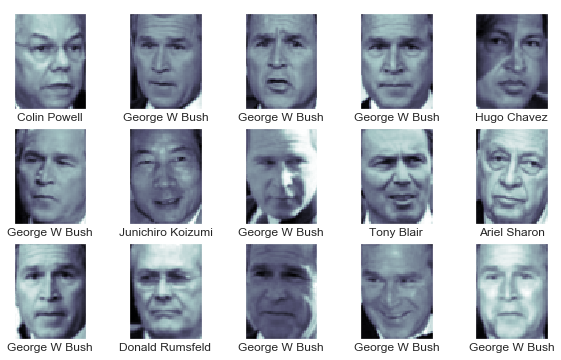

In [106]:
fig, ax = plt.subplots(3, 5,figsize=(10, 6))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

每个图像包含[62×47]、接近3000 像素。虽然可以简单地将每个像素作为一个特征，但是更高效的方法通常是使用预处理器来提取更有意义的特征。这里使用主成分分析来提取150个基本元素，然后将其提供给支持向量机分类器。可以将这个预处理器和分类器打包成管道：

In [107]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

为了测试分类器的训练效果，将数据集分解成训练集和测试集：

In [108]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

最后，用网格搜索交叉检验来寻找最优参数组合。通过不断调整参数C（控制边界线的硬度）和参数gamma（控制径向基函数核的大小），确定最优模型：

In [109]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid, cv=5)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

/home/huiying/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CPU times: user 3min 8s, sys: 952 ms, total: 3min 9s
Wall time: 33.6 s
{'svc__C': 5, 'svc__gamma': 0.001}


最优参数最终落在了网格的中间位置。如果它们落在了边缘位置，我们可能就需要扩展网格搜索范围，确保最优参数可以被搜索到。

有了交叉检验的模型，现在就可以对测试集的数据进行预测了：

In [110]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

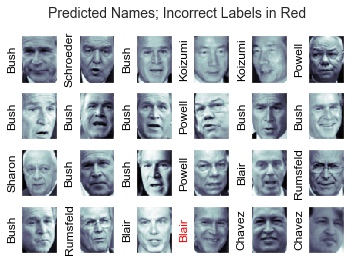

In [111]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

在这个小样本中，我们的最优评估器只判断错了一张照片（最后一行中布什的照片被误判为布莱尔）。我们可以打印分类效果报告，它会列举每个标签的统计结果，从而对评估器的性能有更全面的认识：

In [112]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.87      0.74        15
     Colin Powell       0.82      0.88      0.85        68
  Donald Rumsfeld       0.76      0.84      0.80        31
    George W Bush       0.97      0.81      0.88       126
Gerhard Schroeder       0.69      0.87      0.77        23
      Hugo Chavez       0.88      0.70      0.78        20
Junichiro Koizumi       0.86      1.00      0.92        12
       Tony Blair       0.89      0.98      0.93        42

        micro avg       0.85      0.85      0.85       337
        macro avg       0.82      0.87      0.83       337
     weighted avg       0.87      0.85      0.86       337



还可以画出这些标签的混淆矩阵

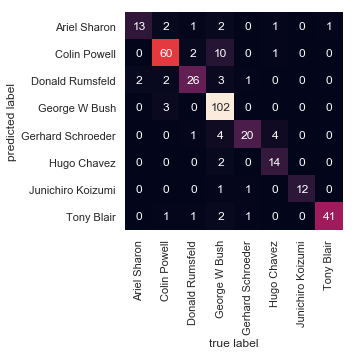

In [113]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

真实环境中的人脸识别问题的照片通常不会被切割得这么整齐（即使像素相同），两类人脸分类机制的唯一差别其实是特征选择：你需要用更复杂的算法找到人脸，然后提取图片中与像素化无关的人脸特征。这类问题有一个不错的解决方案，就是用 OpenCV（http://opencv.org) 配合其他手段，包括最先进的通用图像和人脸图像的特征提取工具，来获取人脸特征数据。

### 支持向量机总结

前面已经简单介绍了支持向量机的基本原则。支持向量机是一种强大的分类方法，主要有四点理由。

* 模型依赖的支持向量比较少，说明它们都是非常精致的模型，消耗内存少。
* 一旦模型训练完成，预测阶段的速度非常快。
* 由于模型只受边界线附近的点的影响，因此它们对于高维数据的学习效果非常好——即使训练比样本维度还高的数据也没有问题，而这是其他算法难以企及的。
* 与核函数方法的配合极具通用性，能够适用不同类型的数据。

但是，SVM 模型也有一些缺点。
* 随着样本量N 的不断增加，最差的训练时间复杂度会达到 [N3]；经过高效处理后，也只能达到 [N2]。因此，大样本学习的计算成本会非常高。
* 训练效果非常依赖于边界软化参数C 的选择是否合理。这需要通过交叉检验自行搜索；当数据集较大时，计算量也非常大。